In [19]:
import openai
import os
import pandas as pd
import time
import json
import requests

/Users/Temp/Data4380/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
#importing module that wraps preprocessing steps
import LLM_Preprocessing as llmp

In [ ]:
#reimport if necessary (edit file after already imported)
import importlib
importlib.reload(llmp)

In [ ]:
#loading grouped dataset
df=llmp.llm_preprocessing('meta_Clothing_Shoes_and_Jewelry.jsonl.gz','Clothing_Shoes_and_Jewelry.jsonl.gz')

In [30]:
#grouping dataset if you have already created csv file and do not want to rerun preprocessing steps
df=pd.read_csv('amazon_watch_reviews.csv')
df=df.groupby("meta_title")["review_text"].apply(list).reset_index()

/var/folders/rs/56dc52116fdc6_zgn1vcs_fr0000gp/T/ipykernel_35204/3890872948.py:2: DtypeWarning: Columns (0,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('amazon_watch_reviews.csv')


In [31]:
#checking dataset
df.head()

,meta_title,review_text
0,"""DESPICABLE ME"" PURPLE BAND WATCH. Minion Wris...","[Cutest watch ever , bought for myself, little..."
1,"""Harry Potter Casts A Spell"" Wrist Watch With ...",[Two kids toy way too expensive for that]
2,"""KOMANDIRSKIE"" VOSTOK Mechanical Watch !!! New...",[I really like this watch. It is very quirky. ...
3,"""Navy Seal Titanium Dive Watch, Black Dial, Ti...",[Please save yourself the agony of a poorly ma...
4,"""Night Chrome"" Wolfram Steel Black Pocket Watc...","[Got these as gifts for my groomsmen, they are..."


In [ ]:
client=openai.OpenAI(api_key='INSERT YOUR API KEY HERE')

#function to call GPT-4.5
def get_pros_cons(reviews):
    prompt=f"""Here are customer reviews for a watch:\n\n{reviews}\n\nPlease extract a list of PROS and CONS from the reviews.

Format:
Pros:
- ...
Cons:
- ..."""

    try:
        response=client.chat.completions.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "system", "content": "You summarize reviews into pros and cons lists."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.7,
            max_tokens=400
        )
        return response.choices[0].message.content
    except Exception as e:
        print("Error:", e)
        return None

#sample (e.g. first 100)
sample_grouped=df.head(100).copy()

results=[]
for i, row in sample_grouped.iterrows():
    output=get_pros_cons(row['review_text'])
    results.append(output)
    time.sleep(1.1) 

sample_grouped["pros_cons"]=results

#save the results; jsonl file with formating that will work with OpenAI fine tuning
with open("labeled_watch_reviews.jsonl", "w") as f:
    for _, row in sample_grouped.iterrows():
        if row["pros_cons"]:
            json_record = {
                "messages": [
                    {"role": "system", "content": "You summarize customer reviews into pros and cons lists."},
                    {"role": "user", "content": row["meta_title"]},
                    {"role": "assistant", "content": row["pros_cons"]}
                ]
            }
            f.write(json.dumps(json_record) + "\n")


In [23]:
print(openai.__version__)

1.97.1


## Fine Tuning GPT-3.5
* Originally tried to do fine tuning in python environment; failed due to fine tuning not available for version of OpenAI API I am using (1.97.1)
* Switched to using the web option
    * Same concept, just using user friendly UI on website instead of assigning values through variables using python (batches, learning rate, epochs)

#### First Attempt
* Uses the prepared 100 samples that has labels (pros and cons list) generated by GPT-4.5
* Model = GPT 3.5 Turbo 1106
* Hyperparameters
    * Batches = 10
    * Learning Rate = 0.0001
    * Epochs = 10
* No validation file prepared for this test

Results
* Loss function looks like a heart rate ECG reading
* Accuracy values flucuated betweem 0.45 and 0.55
* Unsurprising that this model is doing so bad using a dataset of only 100
    * Also doing bad because lack of review text means model is just guessing at what the pros and cons are

### Second Attempt
* Labeling larger set; adjusting what information is being brought into model
    * Making sure reviews are a part of file used to train GPT 3.5
* Sample size = 500 (training = 350, validation = 150)
* Model = GPT 3.5 Turbo 1106
* Hyperparameters
    * Batches = 10
    * Learning Rate = 0.0001
    * Epochs = 10

In [32]:
#sample (e.g. first 500)
df500=df.head(500).copy()

results2=[]
for i, row in df500.iterrows():
    output=get_pros_cons(row['review_text'])
    results2.append(output)
    time.sleep(1.1) 

df500["pros_cons"]=results2

#save the results; jsonl file with formating that will work with OpenAI fine tuning
with open("labeled_watch_reviews500.jsonl", "w") as f:
    for _, row in df500.iterrows():
        if row["pros_cons"]:
            json_record = {
                "messages": [
                    {"role": "system", "content": "You summarize customer reviews into pros and cons lists."},
                    {"role": "user", "content": f'Product: {row["meta_title"]}\n\n Reviews: {row["review_text"]}'},
                    {"role": "assistant", "content": row["pros_cons"]}
                ]
            }
            f.write(json.dumps(json_record) + "\n")


Following was ran in terminal to split the files for train/validation
* head -n 350 labeled_watch_reviews500.jsonl > t2_train.jsonl
* tail -n 150 labeled_watch_reviews500.jsonl > t2_val.jsonl

Results
* Loss function is still not converging to 0
* Train accuracy ranged from 0.60 to 0.80
* Validation accuracy ranged from 0.66 to 0.76

## Giving Scores for similarity between the generated Pros and Cons Lists
* Using GPT 4 again to generate the scores (1-10 scoring system)
* Histogram the scores of the validation set (150)

In [42]:
val_df=df500.tail(150)
val_df.head()

,meta_title,review_text,pros_cons
350,12mm Watch Band Genuine Leather Lizard Grain B...,"[Nice color, grain & appearance, but very stif...",Pros:\n- Nice color\n- Attractive grain and ap...
351,12mm Watch Bracelet Band Link Extender White G...,"[Perfect for what I needed., good quality clas...",Pros:\n- Serves its intended purpose well\n- G...
352,12mm Watch Bracelet Band Link Extender Yellow ...,[Just what I needed to add length to a watch t...,Pros:\n- Adds length to a watch that is too ti...
353,12mm Watch Buckle Watch Band Stainless Steel R...,[works well],Pros:\n- Works well\n\nCons:\n- (No cons menti...
354,12mm Womens Padded Stitched Genuine Leather Wa...,"[Nice band, This band fit my old Timex perfect...",Pros:\n- Fits well for small wrists or for tho...


In [50]:
true_pc=df500['pros_cons'].tail(150) #the validation pro/cons (true labels)
true_pc=list(true_pc)
true_pc

['Pros:\n- Nice color\n- Attractive grain and appearance\n- Perfect band width\n\nCons:\n- Very stiff material\n- Band length is shorter than standard\n- Fits tight on the second hole\n- Might not fit a plus-sized woman',
 'Pros:\n- Serves its intended purpose well\n- Good quality clasp\n\nCons:\n- (No cons mentioned in the reviews provided)',
 'Pros:\n- Adds length to a watch that is too tight\n\nCons:\n- No cons mentioned in the review provided',
 'Pros:\n- Works well\n\nCons:\n- (No cons mentioned)',
 'Pros:\n- Fits well for small wrists or for those who prefer a shorter band\n- Good for replacing old Timex watch bands\n- Quick shipping for customer satisfaction\n- Great value and comes with new spring bar pins for easy installation\n- Good for people with small bone structure\n- Suitable for summer accessories\n\nCons:\n- Band may be too short for people with larger wrists\n- Size may not be accurate, leading to fit issues\n- Potential waste of money if the size does not fit\n- Lea

In [47]:
#using fine tuned GPT-3.5 to generate pros and cons list for comparison
def custom_pros_cons(input):
    prompt=f"""Here are customer reviews for a watch:\n\n{input}\n\nPlease extract a list of PROS and CONS from the reviews.

Format:
Pros:
- ...
Cons:
- ..."""

    try:
        response=client.chat.completions.create(
            model="ft:gpt-3.5-turbo-1106:personal:t2-500:C0rlHwe0", #fine-tuned GPT-3.5
            messages=[
                {"role": "system", "content": "You summarize reviews into pros and cons lists."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.7,
            max_tokens=400,
            timeout=30
        )
        return response.choices[0].message.content
    except Exception as e:
        print("Error:", e)
        return None
    
#generating pro/cons list
pred=[]
for i, row in val_df.iterrows():
    output=custom_pros_cons(row['review_text'])
    pred.append(output)
    time.sleep(1.1)

Error: Request timed out.
Error: Request timed out.


In [48]:
#checking generated list
pred

['Pros:\n- Nice color, grain & appearance\n- Band width was perfect\n\nCons:\n- Very stiff material\n- Shorter length than standard, not suitable for plus-sized women',
 'Pros:\n- Perfect for fixing broken watch clasp\n- Good quality clasp\n\nCons:\n- None mentioned',
 'Pros:\n- Provides additional length for tight-fitting watches\n\nCons:\n- No negative feedback mentioned',
 'Pros:\n- Works well\n\nCons:\n- No specific cons mentioned',
 'Pros:\n- Nice band\n- Fits small wrists well\n- Quick shipping\n- Good value\n- Comes with new spring bar pins\n\nCons:\n- May not fit larger wrists\n- Inconsistent sizing compared to original bands',
 'Pros:\n- Stylish band design\n\nCons:\n- Required professional installation due to loose parts',
 "Pros:\n- Good quality watchband\n- Transformed an antique men's watch into an elegant women's timepiece\n\nCons:\n- Latch pin is too short and won't securely latch",
 'Pros:\n- Nice band\n- Looks good\n\nCons:\n- Small\n- Too tight on wrist\n- Had to retu

In [49]:
#checking number of successful api calls
len(pred)

150

In [68]:
tp_df=pd.DataFrame({'Product':val_df['meta_title'],'GPT 4':true_pc,'FT GPT 3.5':pred}).reset_index()
tp_df=tp_df.drop(columns='index')
tp_df

,Product,GPT 4,FT GPT 3.5
0,12mm Watch Band Genuine Leather Lizard Grain B...,Pros:\n- Nice color\n- Attractive grain and ap...,"Pros:\n- Nice color, grain & appearance\n- Ban..."
1,12mm Watch Bracelet Band Link Extender White G...,Pros:\n- Serves its intended purpose well\n- G...,Pros:\n- Perfect for fixing broken watch clasp...
2,12mm Watch Bracelet Band Link Extender Yellow ...,Pros:\n- Adds length to a watch that is too ti...,Pros:\n- Provides additional length for tight-...
3,12mm Watch Buckle Watch Band Stainless Steel R...,Pros:\n- Works well\n\nCons:\n- (No cons menti...,Pros:\n- Works well\n\nCons:\n- No specific co...
4,12mm Womens Padded Stitched Genuine Leather Wa...,Pros:\n- Fits well for small wrists or for tho...,Pros:\n- Nice band\n- Fits small wrists well\n...
...,...,...,...
145,15473 Watch INVICTA Russian Diver Men 52mm Sta...,"Pros:\n- Attracts positive attention with ""Wow...",Pros:\n- Awesome design\n- Attracts attention\...
146,15mm Black Alligator Grain Italian Leather Wat...,Pros:\n- The watch band design and width were ...,Pros:\n- Matches the desired width and design\...
147,15mm Black Polished Calfskin Leather Watchband...,Pros:\n- Made of decent quality leather.\n- Ca...,Pros:\n- Decent quality leather\n- Fits well f...
148,15mm Black Smooth Leather Gold-Tone Buckle Wat...,Pros:\n- Customer is pleased with the purchase...,Pros:\n- Customer is very pleased with the pur...


In [102]:
print(f"Product: {tp_df['Product'][0]}")
print()
print(f"GPT 4 List (Ground Truth):\n{tp_df['GPT 4'][0]}")
print()
print(f"FT GPT 3.5:\n{tp_df['FT GPT 3.5'][0]}")

Product: 12mm Watch Band Genuine Leather Lizard Grain Brown Quick Release Built-in Pins Ladies Strap

GPT 4 List (Ground Truth):
Pros:
- Nice color
- Attractive grain and appearance
- Perfect band width

Cons:
- Very stiff material
- Band length is shorter than standard
- Fits tight on the second hole
- Might not fit a plus-sized woman

FT GPT 3.5:
Pros:
- Nice color, grain & appearance
- Band width was perfect

Cons:
- Very stiff material
- Shorter length than standard, not suitable for plus-sized women


In [52]:
#using GPT-4.5 to assign a score (1-10) to how similar the two generated pro/cons lists are
def score_comparison(true,pred):
    prompt=f"""Here is pros and cons list generated by GPT 4.5:\n\n{true}\n\nHere is the pros and cons list generated by my fine-tuned GPT-3.5 model:\n\n{pred}\n\nPlease give a score ranging between 1 and 10 for how similar the two lists are, where 1 means they are completely unrelated and 10 means the content in both lists are the same.

Format:
<number between 1 and 10>"""

    try:
        response=client.chat.completions.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "system", "content": "You score how similar two pros and cons lists are using a using a 1-10 score system."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.7,
            max_tokens=400,
            timeout=30
        )
        return response.choices[0].message.content
    except Exception as e:
        print("Error:", e)
        return None
    
scores=[]
for i, row in tp_df.iterrows():
    output=score_comparison(row['GPT 4'],row['FT GPT 3.5'])
    scores.append(output)
    time.sleep(1.1)

In [53]:
len(scores)

150

In [57]:
#making sure scores are numerical (type) not strings
scores=[int(i) for i in scores]

In [60]:
import numpy as np

In [62]:
scores_mean=np.mean(scores)
scores_mean

np.float64(8.98)

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

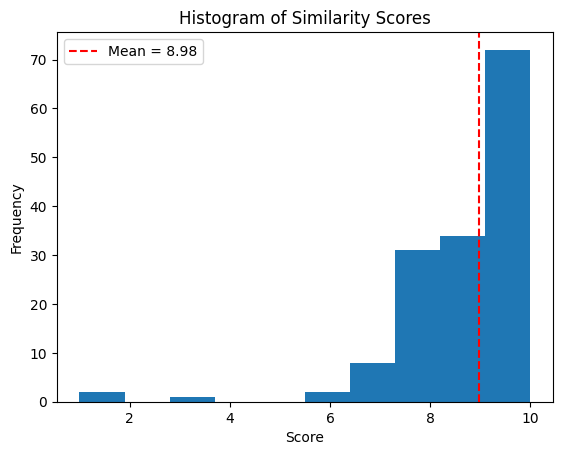

In [65]:
#plotting histogram of scores
plt.hist(scores,bins=10)
plt.title('Histogram of Similarity Scores')
plt.axvline(scores_mean, color='red', linestyle='--', label=f'Mean = {scores_mean}')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

## Comparing Similarity Scores (Fine-Tuned GPT 3.5 model only given product name)
* Given left skewed distribution of Similarity Scores, will be testing how well the Fine-Tuned model does when only given the product name
* Testing on validation set like last time

In [69]:
#using fine tuned GPT-3.5 to generate pros and cons list for comparison
def prod_name_pclists(input):
    prompt=f"""Here is a watch or watch related product name:\n\n{input}\n\nPlease give a list of PROS and CONS for that product.

Format:
Pros:
- ...
Cons:
- ..."""

    try:
        response=client.chat.completions.create(
            model="ft:gpt-3.5-turbo-1106:personal:t2-500:C0rlHwe0", #fine-tuned GPT-3.5
            messages=[
                {"role": "system", "content": "You generate pros and cons lists for products."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.7,
            max_tokens=400,
            timeout=30
        )
        return response.choices[0].message.content
    except Exception as e:
        print("Error:", e)
        return None
    
#generating pro/cons list
name_pred=[]
for i, row in val_df.iterrows():
    output=prod_name_pclists(row['meta_title'])
    name_pred.append(output)
    time.sleep(1.1)

Error: Request timed out.
Error: Request timed out.
Error: Request timed out.
Error: Request timed out.


In [70]:
len(name_pred)

150

In [71]:
tp_df2=pd.DataFrame({'Product':val_df['meta_title'],'GPT 4':true_pc,'FT GPT 3.5; product only':name_pred}).reset_index()
tp_df2=tp_df2.drop(columns='index')
tp_df2

,Product,GPT 4,FT GPT 3.5; product only
0,12mm Watch Band Genuine Leather Lizard Grain B...,Pros:\n- Nice color\n- Attractive grain and ap...,Pros:\n- Genuine leather material for durabili...
1,12mm Watch Bracelet Band Link Extender White G...,Pros:\n- Serves its intended purpose well\n- G...,Pros:\n- Allows for adjusting the length of a ...
2,12mm Watch Bracelet Band Link Extender Yellow ...,Pros:\n- Adds length to a watch that is too ti...,Pros:\n- Allows for adjusting the length of wa...
3,12mm Watch Buckle Watch Band Stainless Steel R...,Pros:\n- Works well\n\nCons:\n- (No cons menti...,Pros:\n- Stainless steel material provides dur...
4,12mm Womens Padded Stitched Genuine Leather Wa...,Pros:\n- Fits well for small wrists or for tho...,Pros:\n- Genuine leather material for durabili...
...,...,...,...
145,15473 Watch INVICTA Russian Diver Men 52mm Sta...,"Pros:\n- Attracts positive attention with ""Wow...",Pros:\n- Large 52mm size makes a bold statemen...
146,15mm Black Alligator Grain Italian Leather Wat...,Pros:\n- The watch band design and width were ...,Pros:\n- Stylish and sleek design\n- Made from...
147,15mm Black Polished Calfskin Leather Watchband...,Pros:\n- Made of decent quality leather.\n- Ca...,Pros:\n- Sleek black polished calfskin leather...
148,15mm Black Smooth Leather Gold-Tone Buckle Wat...,Pros:\n- Customer is pleased with the purchase...,Pros:\n- Sleek and stylish design\n- Compatibl...


In [103]:
print(f"Product: {tp_df2['Product'][0]}")
print()
print(f"GPT 4 List (Ground Truth):\n{tp_df2['GPT 4'][0]}")
print()
print(f"FT GPT 3.5:\n{tp_df2['FT GPT 3.5; product only'][0]}")

Product: 12mm Watch Band Genuine Leather Lizard Grain Brown Quick Release Built-in Pins Ladies Strap

GPT 4 List (Ground Truth):
Pros:
- Nice color
- Attractive grain and appearance
- Perfect band width

Cons:
- Very stiff material
- Band length is shorter than standard
- Fits tight on the second hole
- Might not fit a plus-sized woman

FT GPT 3.5:
Pros:
- Genuine leather material for durability and comfort
- Lizard grain pattern adds a unique and stylish look
- Quick release feature for easy band replacement
- Built-in pins for hassle-free installation
- Suitable for ladies' watches

Cons:
- Limited color option (only available in brown)
- May not fit all watch sizes, as it's specifically designed for 12mm watches


In [72]:
#generating similarity scores
scores2=[]
for i, row in tp_df2.iterrows():
    output=score_comparison(row['GPT 4'],row['FT GPT 3.5; product only'])
    scores2.append(output)
    time.sleep(1.1)

In [73]:
len(scores2)

150

In [74]:
scores2=[int(i) for i in scores2]

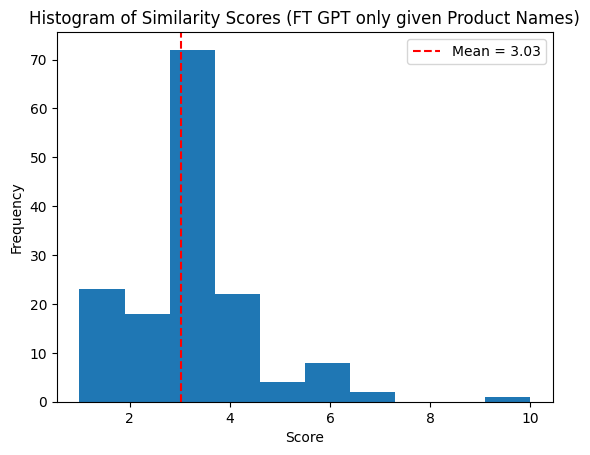

In [77]:
scores2_mean=np.mean(scores2)
scores2_mean

#plotting histogram of scores
plt.hist(scores2,bins=10)
plt.title('Histogram of Similarity Scores (FT GPT only given Product Names)')
plt.axvline(scores2_mean, color='red', linestyle='--', label=f'Mean = {scores2_mean:.2f}')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

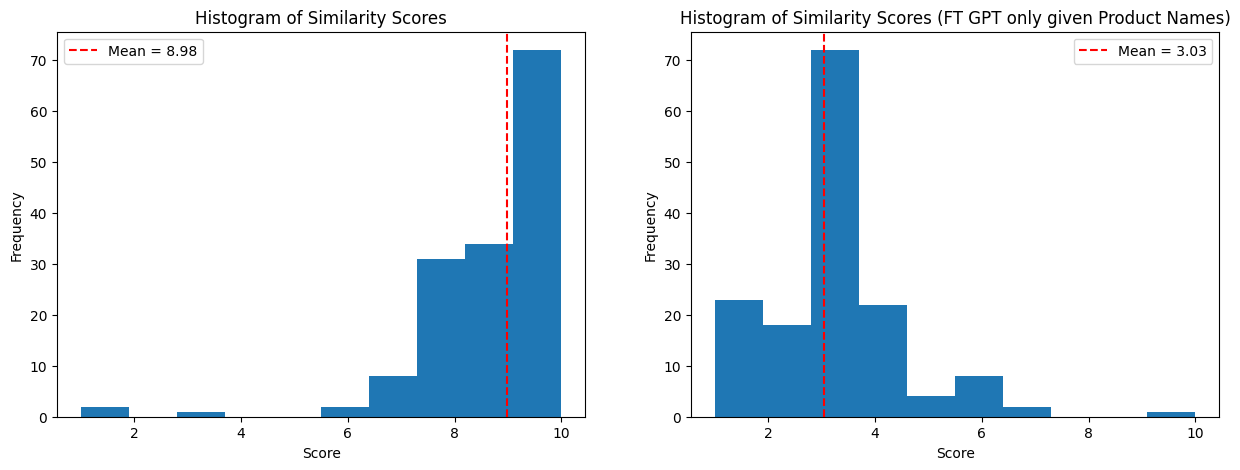

In [78]:
#both histograms next to each other
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(scores,bins=10)
plt.title('Histogram of Similarity Scores')
plt.axvline(scores_mean, color='red', linestyle='--', label=f'Mean = {scores_mean}')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.hist(scores2,bins=10)
plt.title('Histogram of Similarity Scores (FT GPT only given Product Names)')
plt.axvline(scores2_mean, color='red', linestyle='--', label=f'Mean = {scores2_mean:.2f}')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

## Comparing Similarity Scores (Product Name only; taken from training set)
* Using Product Name as only input, trying to get LLM to recall reviews it read and link it to the product name
* Using training set

In [79]:
train=df500.head(350)
train

,meta_title,review_text,pros_cons
0,"""DESPICABLE ME"" PURPLE BAND WATCH. Minion Wris...","[Cutest watch ever , bought for myself, little...","Pros:\n- Aesthetic appeal (""Cutest watch ever""..."
1,"""Harry Potter Casts A Spell"" Wrist Watch With ...",[Two kids toy way too expensive for that],Pros:\n- (No pros mentioned)\n\nCons:\n- Perce...
2,"""KOMANDIRSKIE"" VOSTOK Mechanical Watch !!! New...",[I really like this watch. It is very quirky. ...,Pros:\n- Quirky and catches the eye\n- Mechani...
3,"""Navy Seal Titanium Dive Watch, Black Dial, Ti...",[Please save yourself the agony of a poorly ma...,Pros:\n- (No positive aspects mentioned in the...
4,"""Night Chrome"" Wolfram Steel Black Pocket Watc...","[Got these as gifts for my groomsmen, they are...","Pros:\n- Affordable price, suitable for giftin..."
...,...,...,...
345,12mm Tan Snakeskin Leather with Quick-Release ...,"[Loved it, nicer than expected, great color!]",Pros:\n- Loved by customer\n- Nicer than expec...
346,12mm Teal Blue Croc Quick Release Genuine Leat...,"[In two days, the color was coming off!]",Pros:\n\nCons:\n- Color started coming off wit...
347,12mm Turquoise Italian Leather Alligator Grain...,[Great color and fast delivery.],Pros:\n- Great color\n- Fast delivery\n\nCons:...
348,12mm Two-Tone White/Yellow Ladies Metal Watch ...,[Its nice for the price],Pros:\n- Good value for the price\n\nCons:\n- ...


In [81]:
true_train=train['pros_cons'] #the train pro/cons (true labels)
true_train=list(true_train)
true_train

['Pros:\n- Aesthetic appeal ("Cutest watch ever")\n- Personal satisfaction ("Love it")\n\nCons:\n- Size issue ("little small")',
 'Pros:\n- (No pros mentioned)\n\nCons:\n- Perceived as too expensive for its quality\n- Compared to a toy, suggesting it is not suitable for adults or lacks sophistication',
 'Pros:\n- Quirky and catches the eye\n- Mechanical and fairly accurate\n- Tough and durable\n- Good value, especially for a sub-$100 watch\n- Has loads of character and a great story\n- Fast shipping for some customers\n- Good as a beater watch, with decent timekeeping (+/- 5 sec a day)\n- Liked by many users, some of whom own multiple models from the company\n\nCons:\n- Must be wound daily\n- Setting the date is a hassle\n- Some find the original strap to be of poor quality and recommend replacing it\n- One customer reported the watch did not work properly\n- Crown can be wobbly and make setting time/date a pain\n- The bezel may have a different gloss level than the dial, which might n

In [82]:
#FT GPT-3.5 to generate pros/cons list from product name
train_pred=[]
for i, row in train.iterrows():
    output=prod_name_pclists(row['meta_title'])
    train_pred.append(output)
    time.sleep(1.1)

Error: Request timed out.
Error: Request timed out.
Error: Request timed out.
Error: Request timed out.
Error: Request timed out.
Error: Request timed out.
Error: Request timed out.


In [83]:
train_comp=pd.DataFrame({'Product':train['meta_title'],'GPT 4':true_train,'FT GPT 3.5; product only (train)':train_pred})
train_comp

,Product,GPT 4,FT GPT 3.5; product only (train)
0,"""DESPICABLE ME"" PURPLE BAND WATCH. Minion Wris...","Pros:\n- Aesthetic appeal (""Cutest watch ever""...",Pros:\n- Fun and playful design featuring the ...
1,"""Harry Potter Casts A Spell"" Wrist Watch With ...",Pros:\n- (No pros mentioned)\n\nCons:\n- Perce...,Pros:\n- Unique design inspired by the Harry P...
2,"""KOMANDIRSKIE"" VOSTOK Mechanical Watch !!! New...",Pros:\n- Quirky and catches the eye\n- Mechani...,Pros:\n- Mechanical movement provides a tradit...
3,"""Navy Seal Titanium Dive Watch, Black Dial, Ti...",Pros:\n- (No positive aspects mentioned in the...,Pros:\n- Durable and rugged titanium construct...
4,"""Night Chrome"" Wolfram Steel Black Pocket Watc...","Pros:\n- Affordable price, suitable for giftin...",Pros:\n- Stylish and elegant design\n- Durable...
...,...,...,...
345,12mm Tan Snakeskin Leather with Quick-Release ...,Pros:\n- Loved by customer\n- Nicer than expec...,Pros:\n- Stylish and luxurious snakeskin leath...
346,12mm Teal Blue Croc Quick Release Genuine Leat...,Pros:\n\nCons:\n- Color started coming off wit...,Pros:\n- Stylish and fashionable design with c...
347,12mm Turquoise Italian Leather Alligator Grain...,Pros:\n- Great color\n- Fast delivery\n\nCons:...,None
348,12mm Two-Tone White/Yellow Ladies Metal Watch ...,Pros:\n- Good value for the price\n\nCons:\n- ...,Pros:\n- Stylish two-tone design\n- Curved end...


In [91]:
#editing function, keeps giving me comparison instead of a score
def score_comparison(true,pred):
    prompt=f"""Here is pros and cons list generated by GPT 4.5:\n\n{true}\n\nHere is the pros and cons list generated by my fine-tuned GPT-3.5 model:\n\n{pred}\n\nPlease give a score ranging between 1 and 10 for how similar the two lists are, where 1 means they are completely unrelated and 10 means the content in both lists are the same. Do NOT give me any explanation, merely give me a single numerical score.

Format:
<number between 1 and 10>"""

    try:
        response=client.chat.completions.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "system", "content": "You score how similar two pros and cons lists are using a using a 1-10 score system."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.7,
            max_tokens=400,
            timeout=30
        )
        return response.choices[0].message.content
    except Exception as e:
        print("Error:", e)
        return None

In [92]:
#generating similarity scores
scores3=[]
for i, row in train_comp.iterrows():
    output=score_comparison(row['GPT 4'],row['FT GPT 3.5; product only (train)'])
    scores3.append(output)
    time.sleep(1.1)

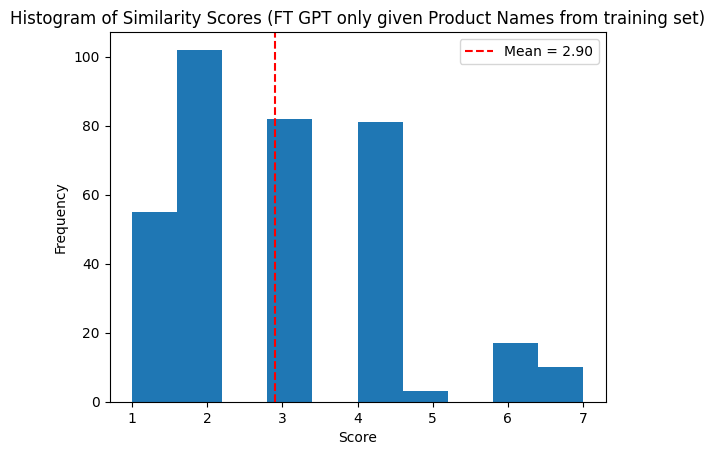

In [94]:
scores3=[int(i) for i in scores3]

scores3_mean=np.mean(scores3)
scores3_mean

#plotting histogram of scores
plt.hist(scores3,bins=10)
plt.title('Histogram of Similarity Scores (FT GPT only given Product Names from training set)')
plt.axvline(scores3_mean, color='red', linestyle='--', label=f'Mean = {scores3_mean:.2f}')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()